This is the start 
For a simple comprehensive tutorial from gammapy, one can follow https://docs.gammapy.org/0.18.2/tutorials/spectrum_analysis.html

Here we break the post-DL3 analyses to simple and separate sections to ease the facilitation of all steps - 
# 1. Reduce DL3 data into Spectrum Dataset objects in OGIP files
# 2. Plot LC from the OGIP files
# 3. Plot SEDs from the OGIP files

# This example notebook, converts the provided DL3 files into Spectrum Dataset objects and saves the 1D counts spectra and Associated Response Function in OGIP format, as following:

## 1. Read the provided DL3 index files
## 2. Apply selection filters to the list of DL3 files
## 3. Define base geometry for the 1D spectrum
## 4. Generate some dataset makers for data reduction
## 5. Perform data reduction over all selected observations and compile them to a Dataset
## 6. Save the Dataset to OGIP files

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from regions import CircleSkyRegion
from pathlib import Path
import os

In [2]:
from gammapy.data import DataStore

from gammapy.maps import Map, MapAxis, WcsNDMap, WcsGeom, RegionGeom
from gammapy.data import DataStore

from gammapy.datasets import (
    Datasets,
    SpectrumDataset,
    SpectrumDatasetOnOff,
)
from gammapy.makers import (
    SafeMaskMaker,
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)

from gammapy.visualization import plot_spectrum_datasets_off_regions

import astropy.units as u
from astropy.table import Table
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle

# 1. Parameters from user for selection of observations

In [3]:
# Use the DL3 files produced for source dependent or independent analyses
base_dir = "/fefs/aswg/workspace/chaitanya.priyadarshi"
dir_path = base_dir + "/notebooks/LST_Analysis_School_2022/DL3_src_indep_final/"

total_datastore = DataStore.from_dir(dir_path)

plot_path = Path(dir_path + 'plots/')
ogip_path = Path(dir_path + 'OGIP/')

plot_path.mkdir(exist_ok=True)
ogip_path.mkdir(exist_ok=True)

# 2. Selection filters for the observations

In [4]:
# Get the object name from the OBS Table, assuming all the DL3 files are of the same single source.
# If not, then select a single object, to produce the relevant Spectrum Dataset file

obj_name = np.unique(total_datastore.obs_table["OBJECT"])[0]
print("The source is", obj_name)

max_zen = 30 # in deg for a maximum limit on zenith pointing of observations
min_time = 300 # in seconds for minimum livetime of each observation

The source is Crab


In [5]:
total_obs_list = total_datastore.obs_table["OBS_ID"].data
observations_total = total_datastore.get_observations(total_obs_list)

No HDU found matching: OBS_ID = 2967, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2967, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2972, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2972, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2973, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2973, HDU_TYPE = psf, HDU_CLASS = None
No HDU

In [6]:
# If you want to see the full Obs table, run this cell
total_datastore.obs_table

OBS_ID,DATE-OBS,TIME-OBS,DATE-END,TIME-END,RA_PNT,DEC_PNT,ZEN_PNT,ALT_PNT,AZ_PNT,RA_OBJ,DEC_OBJ,TSTART,TSTOP,ONTIME,TELAPSE,LIVETIME,DEADC,OBJECT,OBS_MODE,N_TELS,TELLIST,INSTRUME
,,,,,deg,deg,deg,deg,deg,deg,deg,s,s,s,s,s,,,,,,
int64,bytes10,bytes12,bytes10,bytes12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes4,bytes6,int64,bytes5,bytes5
2967,2020-11-21,00:27:41.949,2020-11-21,00:47:39.583,83.97004257137505,22.24530742887652,29.732219820109158,60.26778017989084,95.17577361000707,83.63308333,22.0145,1605918461.948865,1605919659.583141,1196.639870882034,1197.634275913239,1149.988205508068,0.9610144484492402,Crab,WOBBLE,1,LST-1,LST-1
2968,2020-11-21,00:49:07.551,2020-11-21,01:08:52.833,83.26649188127247,21.78727828475309,24.644129286465912,65.35587071353409,100.4389391756115,83.63308333,22.0145,1605919747.551059,1605920932.833492,1182.285777568817,1185.282433271408,1134.331009923455,0.9594389372221211,Crab,WOBBLE,1,LST-1,LST-1
2969,2020-11-21,01:10:05.044,2020-11-21,01:29:48.847,83.97196330127397,22.24484450444434,20.576248490410606,69.4237515095894,103.5294881362074,83.63308333,22.0145,1605921005.043805,1605922188.846951,1181.815325260162,1183.803146123886,1132.395291687877,0.9581829474402809,Crab,WOBBLE,1,LST-1,LST-1
2970,2020-11-21,01:31:05.784,2020-11-21,01:50:48.103,83.26926193186183,21.78671531937169,15.806710775486678,74.19328922451332,112.7274981260833,83.63308333,22.0145,1605922265.783684,1605923448.10268,1180.322825431824,1182.31899523735,1129.404207074757,0.9568604306720593,Crab,WOBBLE,1,LST-1,LST-1
2971,2020-11-21,01:52:06.553,2020-11-21,02:11:57.547,83.97488474600792,22.24478141506711,11.974578308930873,78.02542169106913,120.7416399361625,83.63308333,22.0145,1605923526.552607,1605924717.547404,1189.995587110519,1190.994797468185,1137.239771866555,0.9556672177482076,Crab,WOBBLE,1,LST-1,LST-1
2972,2020-11-21,02:13:04.303,2020-11-21,02:32:51.148,83.26938274609692,21.78637577536815,8.456185607133747,81.54381439286625,145.5424713719346,83.63308333,22.0145,1605924784.303458,1605925971.14784,1185.846040725708,1186.84438252449,1132.911096118316,0.9553610310365438,Crab,WOBBLE,1,LST-1,LST-1
2973,2020-11-21,02:34:12.986,2020-11-21,02:53:58.082,83.97788837191327,22.24392982902823,6.650280392114226,83.34971960788577,175.3413477815111,83.63308333,22.0145,1605926052.986249,1605927238.082328,1184.09685921669,1185.096079111099,1131.106187027389,0.9552480257194873,Crab,WOBBLE,1,LST-1,LST-1
2974,2020-11-21,02:55:10.354,2020-11-21,03:15:02.371,83.2715938922083,21.78635039916637,8.551754635131715,81.44824536486828,215.4690377991381,83.63308333,22.0145,1605927310.353878,1605928502.371439,1191.018638849258,1192.017561435699,1137.902026660467,0.9554023669687387,Crab,WOBBLE,1,LST-1,LST-1


# 3. Make selection of observations

In [7]:
d_wob = [total_datastore.obs_table["OBS_MODE"]=='WOBBLE']

d_time = [total_datastore.obs_table["LIVETIME"]>min_time]
d_zen = [total_datastore.obs_table["ZEN_PNT"]<max_zen]
d_obj = [total_datastore.obs_table["OBJECT"]==obj_name]

wob_obs_table = total_datastore.obs_table[d_wob[0]*d_zen[0]*d_obj[0]*d_time[0]]
wob_obs_list = total_datastore.obs_table[d_wob[0]*d_zen[0]*d_obj[0]*d_time[0]]["OBS_ID"]

observations_wob = total_datastore.get_observations(wob_obs_list.data)

No HDU found matching: OBS_ID = 2967, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2967, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2968, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2969, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2970, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2971, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2972, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2972, HDU_TYPE = psf, HDU_CLASS = None
No HDU found matching: OBS_ID = 2973, HDU_TYPE = bkg, HDU_CLASS = None
No HDU found matching: OBS_ID = 2973, HDU_TYPE = psf, HDU_CLASS = None
No HDU

In [8]:
print('Wobble observation runs selected are:', wob_obs_list.data)
print(f'Total livetime of all observations: {total_datastore.obs_table["LIVETIME"].data.sum()/3600:.3f} hrs')
print(f'Total livetime of all selected wobble observations {wob_obs_table["LIVETIME"].data.sum()/3600:.3f} hrs')

Wobble observation runs selected are: [2967 2968 2969 2970 2971 2972 2973 2974 2975 2976 2977]
Total livetime of all observations: 3.461 hrs
Total livetime of all selected wobble observations 3.461 hrs


# 4. Some small functions to get parameters for constructing the Geom for SpectrumDataset

In [24]:
# Take it as an exercise?
def get_theta_cut_for_geom(dir_path):
    filename_list = []
    for file in os.listdir(dir_path):
        if file.startswith('dl3'):
            filename_list.append(file)
    filename_list = np.sort(filename_list)
    
    theta_cut = u.Quantity(
        Table.read(
            dir_path+filename_list[0], 
            hdu="EFFECTIVE AREA"
        ).meta["RAD_MAX"]
    )
    
    return theta_cut, filename_list


In [15]:
total_datastore.hdu_table

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,FILE_NAME,HDU_NAME,SIZE
int64,bytes8,bytes8,bytes1,bytes26,bytes17,int64
2967,events,events,.,dl3_LST-1.Run02967.fits.gz,EVENTS,46273096
2967,gti,gti,.,dl3_LST-1.Run02967.fits.gz,GTI,46273096
2967,pointing,pointing,.,dl3_LST-1.Run02967.fits.gz,POINTING,46273096
2967,aeff,aeff_2d,.,dl3_LST-1.Run02967.fits.gz,EFFECTIVE AREA,46273096
2967,edisp,edisp_2d,.,dl3_LST-1.Run02967.fits.gz,ENERGY DISPERSION,46273096
2968,events,events,.,dl3_LST-1.Run02968.fits.gz,EVENTS,48726839
2968,gti,gti,.,dl3_LST-1.Run02968.fits.gz,GTI,48726839
2968,pointing,pointing,.,dl3_LST-1.Run02968.fits.gz,POINTING,48726839
2968,aeff,aeff_2d,.,dl3_LST-1.Run02968.fits.gz,EFFECTIVE AREA,48726839


# 5. Define Target position and energy ranges for reconstructed events

In [14]:
target_position = SkyCoord.from_name(obj_name, frame='icrs')

In [29]:
# Long way to find the theta cut used for creating the IRFs

# Select the HDU entry of the first selected wobble observation
hdu_t = total_datastore.hdu_table
hdu_idx = np.where(hdu_t["OBS_ID"] == wob_obs_list[0])[0][0]

hdu_sel = hdu_t[hdu_idx]
print("Base directory of the HDU index file,", hdu_sel.meta["BASE_DIR"])
print("Location of the selected DL3 file, with respect to HDU index file,", hdu_sel["FILE_DIR"])
print("File name of the selected observation,", hdu_sel["FILE_NAME"])

file = Path(hdu_sel.meta["BASE_DIR"]) / hdu_sel["FILE_DIR"] / hdu_sel["FILE_NAME"]

# Checking the fixed global theta cut value, stored as RAD_MAX metadata in all IRF HDUs
theta_cut = Table.read(file, hdu="EFFECTIVE AREA").meta["RAD_MAX"]
print("Theta cut applied for creating the IRF in the selected DL3 file,", theta_cut)

# Converting the string data into astropy.units
on_region_radius = u.Quantity(theta_cut)

Base directory of the HDU index file, /fefs/aswg/workspace/chaitanya.priyadarshi/notebooks/LST_Analysis_School_2022/DL3_src_indep_final
Location of the selected DL3 file, with respect to HDU index file, .
File name of the selected observation, dl3_LST-1.Run02967.fits.gz
Theta cut applied for creating the IRF in the selected DL3 file, 0.2 deg


In [30]:
# Provide the minimum, maximum energies in TeV units, and number of bins per decade, to create the 
# required reconstructed and spectral fit energy ranges.

e_reco_min = 0.01 * u.TeV
e_reco_max = 40 * u.TeV

# The following units will be used now to restrict the events in the Spectrum Dataset, only within 
# the energy ranges, in which we want to perform spectral analysis.
e_fit_min = 0.01 * u.TeV
e_fit_max = 40 * u.TeV

# Using bins per decade
e_reco_bin_p_dec = 5

# Calculating the bin size in log scale for the given number of bins per decade
e_reco_bin = int(
    round(
        (np.log10(e_reco_max.value) - np.log10(e_reco_min.value)) * e_reco_bin_p_dec + 1, 0
    )
)

e_reco = MapAxis.from_edges(
    np.logspace(
        np.log10(e_reco_min.value), 
        np.log10(e_reco_max.value), 
        e_reco_bin
    ), 
    unit="TeV", name="energy", interp="log"
)

# 6. Define the base Map geometries for creating the SpectrumDataset

In [58]:
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

# This will create the base geometry in which to bin the events based on their reconstructed positions
# One can also vary the different parameters here, to get required plots
geom = WcsGeom.create(
    skydir=target_position, npix=(100, 100), 
    binsz=0.05, frame="icrs", axes=[e_reco]
)

/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


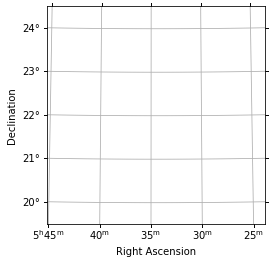

In [59]:
# Exclusion region/source for Crab - RGB J0521+212. 
# Can include specific close gamma-ray objects with respect to the given source, after looking at catalogs
# like http://gamma-sky.net/
RGB_region = CircleSkyRegion(
    center=SkyCoord(183.604, -8.708, unit="deg", frame="galactic"),
    radius=0.5 * u.deg,
)

exclusion_regions = [RGB_region]
exclusion_mask = geom.to_image().region_mask(exclusion_regions, inside=False)

exclusion_mask = WcsNDMap(geom.to_image(), exclusion_mask)
exclusion_mask.plot()
plt.grid()

# 7. Data Reduction chain

In [33]:
# Create some Dataset and Data Reduction Makers
dataset_empty = SpectrumDataset.create(
    e_reco=e_reco, region=on_region
)
# When not including a PSF IRF, put the containment_correction as False
dataset_maker = SpectrumDatasetMaker(
    containment_correction=False, 
    selection=["counts", "exposure", "edisp"]
)

In [56]:
# The following makers can be tuned and played to check the final Dataset to be used.

# Select the necessary number and size of the OFF regions, to be chosen by this method
bkg_maker = ReflectedRegionsBackgroundMaker(
    exclusion_mask=exclusion_mask,
    min_distance_input=2 * u.rad, # Minimum distance from input region
    max_region_number=10 # Maximum number of OFF regions
) 
# Can also include other parameters, by checking the documentation,
# https://docs.gammapy.org/0.18.2/api/gammapy.makers.ReflectedRegionsBackgroundMaker.html#gammapy.makers.ReflectedRegionsBackgroundMaker

In [57]:
# Maker for safe energy range for the events.
safe_mask_masker = SafeMaskMaker(
    methods=["aeff-max"], 
    aeff_percent=10
)
# For other arguments and options, check the documentation,
# https://docs.gammapy.org/0.18.2/api/gammapy.makers.SafeMaskMaker.html#gammapy.makers.SafeMaskMaker

# 8. Generate the Spectrum Dataset for all observations

In [35]:
%%time
# The final object will be stored as a Datasets object
datasets = Datasets()

for obs_id, observation in zip(wob_obs_list, observations_wob):
    dataset = dataset_maker.run(
        dataset_empty.copy(name=str(obs_id)), 
        observation
    )
    print('obs_id:', obs_id)
    
    dataset_on_off = bkg_maker.run(
        dataset=dataset, 
        observation=observation
    )
    
    # Some energy masks based on maximum reconstructed energy or spectral fit energy range
    # This maybe ignored if the events with full energy range are required.
    mask_fit = Map.from_geom(
        geom = dataset_on_off.counts.geom, 
        data = dataset_on_off.counts.geom.get_coord()["energy"] < e_reco_max
    )
    dataset_on_off.counts.geom.energy_mask(
        energy_min=e_fit_min, 
        energy_max=e_fit_max
    )
    dataset_on_off.mask_fit = mask_fit
    
    # Add the name of the observed source
    dataset_on_off.meta_table["SOURCE"]=obj_name
    
    # Check the LC and SEDs by applying the safe mask to see the distinction.
    #dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    
    datasets.append(dataset_on_off)    

obs_id: 2967
obs_id: 2968
obs_id: 2969
obs_id: 2970
obs_id: 2971
obs_id: 2972
obs_id: 2973
obs_id: 2974
obs_id: 2975
obs_id: 2976
obs_id: 2977
CPU times: user 1min 48s, sys: 20.9 s, total: 2min 9s
Wall time: 2min 9s


In [55]:
print(datasets[0])

SpectrumDatasetOnOff
--------------------

  Name                            : 2967 

  Total counts                    : 7198 
  Total off counts                : 6305.00
  Total background counts         : 6305.00
  Total excess counts             : 893.00

  Predicted counts                : 6751.50
  Predicted background counts     : 6751.50
  Predicted excess counts         : nan

  Exposure min                    : 2.22e+05 m2 s
  Exposure max                    : 3.69e+08 m2 s

  Acceptance mean                 : 1.000
  Acceptance off                  : 18.000

  Number of total bins            : 18 
  Number of fit bins              : 18 

  Fit statistic type              : wstat
  Fit statistic value (-2 log(L)) : 244.10

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0




# 9. Some plots with the given Dataset

/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/astropy/visualization/mpl_normalize.py:164: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)


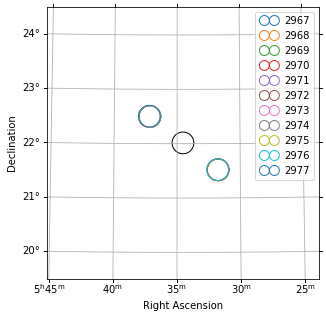

In [36]:
# Check the OFF regions used for calculation of excess
plt.figure(figsize=(8, 5))
_, ax, _ = exclusion_mask.plot()
on_region.to_pixel(ax.wcs).plot(ax=ax, edgecolor="k")
plot_spectrum_datasets_off_regions(ax=ax, datasets=datasets, legend=True)
plt.grid()

# If need be, redo section 7 and 8, to be sure of the final dataset.
# This could be in the case of using source-dependent dataset

Text(0, 0.5, 'Dec (deg)')

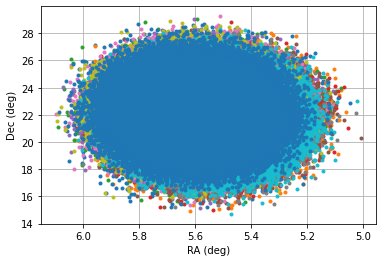

In [66]:
# For source dependent analysis, check the reconstructed position of all the events, 
# to be sure on the type of dateset we have
for o in observations_wob:
    table=o.events.table
    plt.plot((table["RA"]*24/360),(table["DEC"]), '.')
plt.grid()
plt.gca().invert_xaxis()
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
#plt.xlim(22.13,21.95)

In [33]:
info_table = datasets.info_table(cumulative=True)
info_table

name,counts,background,excess,sqrt_ts,npred,npred_background,npred_signal,exposure_min,exposure_max,livetime,ontime,counts_rate,background_rate,excess_rate,n_bins,n_fit_bins,stat_type,stat_sum,counts_off,acceptance,acceptance_off,alpha
,,,,,,,,m2 s,m2 s,s,s,1 / s,1 / s,1 / s,,,,,,,,
str4,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,str5,float64,float32,float64,float64,float64
2967,7198.0,6305.0,893.0,7.687671756804153,6751.5,6751.5,nan,222391.28306411376,368617828.2596869,1150.9438431106662,1197.6342759132385,6.253997571719834,5.4781126270760705,0.7758849446437638,18,18,wstat,244.09581449970162,6305.0,18.0,18.0,1.0
2967,14629.0,12910.0,1719.0,10.36198551307795,13769.5,13769.5,nan,442128.0923127483,732835815.1247268,2288.1499611966356,2382.9167091846466,6.393374668655659,5.64211271941654,0.7512619492391195,18,18,wstat,494.77468365506627,12910.0,18.0,18.0,1.0
2967,22392.0,19659.0,2733.0,13.332283659078652,21025.5,21025.5,nan,661303.3641242598,1096123042.8893788,3422.449948938698,3566.7198553085327,6.542681510052108,5.744130752327366,0.7985507577247415,18,18,wstat,721.1317766004704,19659.0,18.0,18.0,1.0
2967,30305.0,26846.0,3459.0,14.473426919412068,28575.5,28575.5,nan,879901.718855156,1458454019.4988046,4553.764211913265,4749.038850545883,6.654933938107293,5.895342567313262,0.7595913707940316,18,18,wstat,892.2102971765854,26846.0,18.0,18.0,1.0
2967,38468.0,34207.0,4261.0,15.81042556426048,36337.5,36337.5,nan,1099829.5439758392,1822988618.8449972,5691.9588963622755,5940.033648014069,6.758306006844999,6.009706082357983,0.7485999244870163,18,18,wstat,1008.2441663925756,34207.0,18.0,18.0,1.0
2967,46947.0,41423.0,5524.0,18.588435312496824,44185.0,44185.0,nan,1318920.7406751323,2186136490.494384,6825.823769330803,7126.878030538559,6.877851170277523,6.068571559980528,0.8092796102969954,18,18,wstat,1244.2893038984882,41423.0,18.0,18.0,1.0
2967,54936.0,49049.0,5887.0,18.261010384941272,51992.5,51992.5,nan,1537663.3238438342,2548706528.5129833,7957.884459189586,8311.974109649658,6.903342249027145,6.163572775093425,0.7397694739337193,18,18,wstat,1383.2118056285738,49049.0,18.0,18.0,1.0
2967,63298.0,56232.0,7066.0,20.443807650474138,59765.0,59765.0,nan,1757719.0089783303,2913453058.2908173,9096.740858853556,9503.991671085358,6.958316278559717,6.181554566905273,0.7767617116544434,18,18,wstat,1555.7096990954913,56232.0,18.0,18.0,1.0


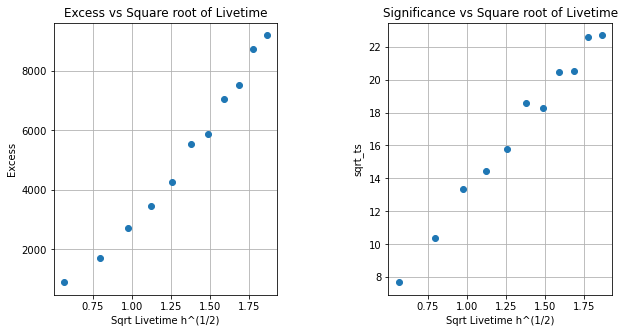

In [34]:
# Plot temporal evolution of excess events and significance value
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")), info_table["excess"], marker="o", ls="none"
)
plt.plot(info_table["livetime"].to("h")[-1:1], info_table["excess"][-1:1], 'r')
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("Excess")
plt.grid()
plt.title('Excess vs Square root of Livetime')

plt.subplot(122)
plt.plot(
    np.sqrt(info_table["livetime"].to("h")),
    info_table["sqrt_ts"],
    marker="o",
    ls="none",
)
plt.grid()
plt.xlabel("Sqrt Livetime h^(1/2)")
plt.ylabel("sqrt_ts")
plt.title('Significance vs Square root of Livetime')
plt.subplots_adjust(wspace=0.5)


/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/gammapy/irf/edisp_kernel.py:536: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  caxes = ax.pcolormesh(x, y, z.T, **kwargs)
/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/gammapy/irf/edisp_kernel.py:536: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  caxes = ax.pcolormesh(x, y, z.T, **kwargs)
/home/chaitanya.priyadarsh/anaconda3/envs/lst-dev/lib/python3.8/site-packages/gammapy/irf/edisp_kernel.py:536: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two min

CPU times: user 2.46 s, sys: 2.23 s, total: 4.69 s
Wall time: 1.85 s


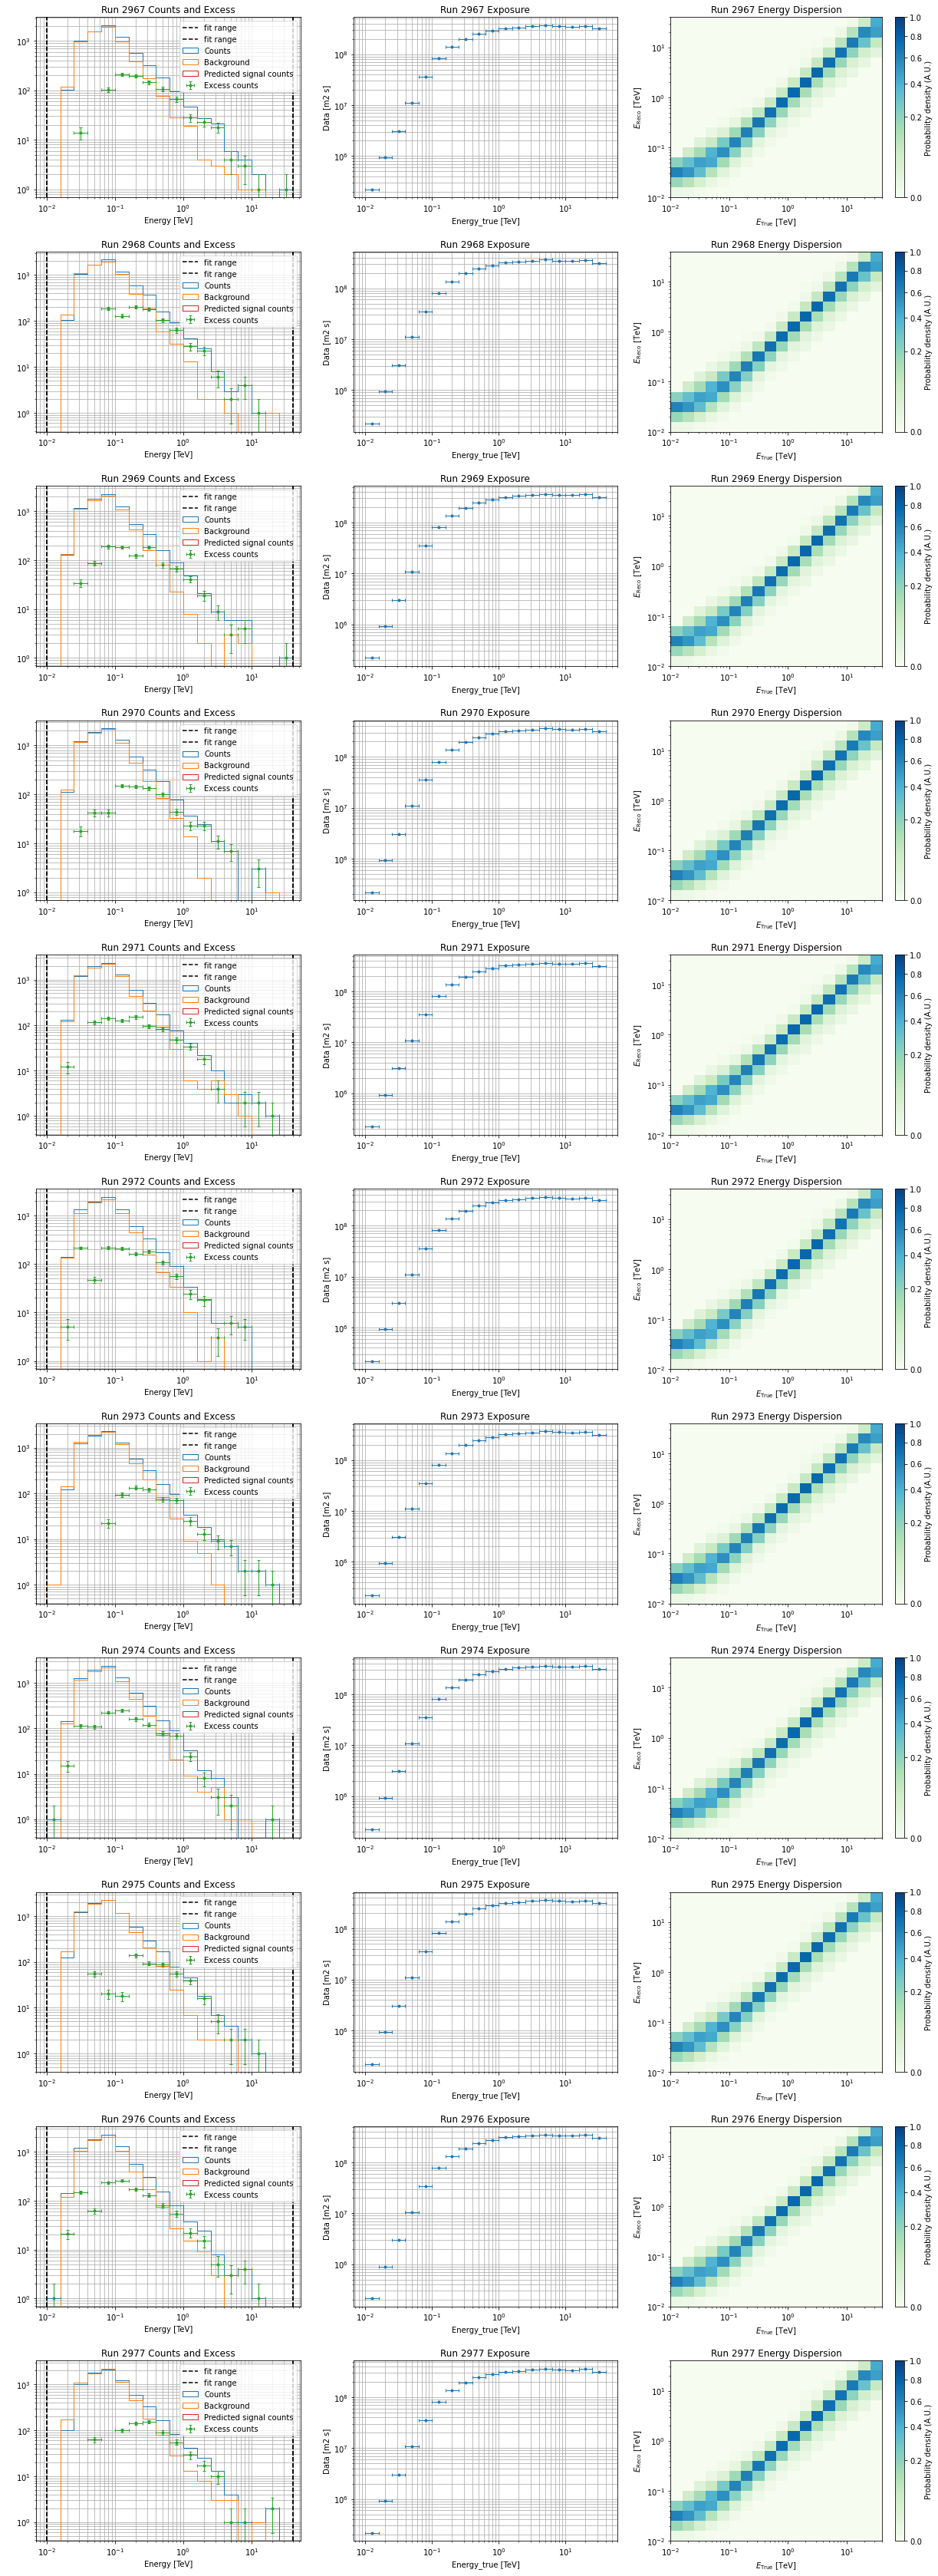

In [81]:
%%time
# Plot the counts+excess, exposure and energy migration of each selected dataset
plt.figure(figsize=(21, len(datasets)*5.5))
j=1
hist_kwargs = {"vmin":0, "vmax":1}

for data in datasets:
    plt.subplot(len(datasets), 3, j)
    data.plot_counts()
    data.plot_excess()
    plt.grid(which="both")
    plt.title(f'Run {data.name} Counts and Excess')
    j += 1
    
    plt.subplot(len(datasets), 3, j)
    data.exposure.plot()
    plt.grid(which='both')
    plt.title(f'Run {data.name} Exposure')
    j += 1
    
    plt.subplot(len(datasets), 3, j)
    if data.edisp is not None:
        kernel = data.edisp.get_edisp_kernel()
        kernel.plot_matrix(add_cbar=True, **hist_kwargs)
        plt.title(f'Run {data.name} Energy Dispersion')
    j += 1
plt.subplots_adjust(hspace=0.3)

# 10. Write all datasets into OGIP files

In [67]:
# Once the latest dependencies are updated, these warnings will go away
for d in datasets:
    d.to_ogip_files(
        outdir=ogip_path, overwrite=True
    )

        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
        Use `regions.Regions.serialize` instead. [gammapy.maps.region]
      

In [68]:
# Read the OGIP files to include the source object name in its headers, to be used for further analysis
for obs in wob_obs_list:
    file = ogip_path/f"pha_obs{obs}.fits"
    
    d1 = fits.open(file)
    d1["REGION"].header["OBJECT"]=obj_name
    d1.writeto(file, overwrite=True)